In [283]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [284]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [285]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [286]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pickle
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, silhouette_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split
from umap.umap_ import UMAP

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel

from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [287]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

y_train_splitter = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/y_train_splitter.csv', index_col = 0)

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df_nan = train_df[train_df['Epsilon'].isna()]
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)
train_df = pd.concat([train_df, train_df_nan], axis = 0, ignore_index = True)
train_df.columns = train_df.columns.str.strip()

# Data Pre-Processing

In [288]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

y_encoder = LabelEncoder()
y_train_alpha = y_encoder.fit_transform(train_df['Alpha'])
y_train_beta = y_encoder.fit_transform(train_df['Beta'])
y_train_delta = y_encoder.fit_transform(train_df['Delta'])
y_train_gamma = y_encoder.fit_transform(train_df['Gamma'])

In [289]:
# impute data
knn_imputer = KNNImputer(n_neighbors = 10, weights = 'distance')
imputed = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputed, columns = X_train.columns, index = X_train.index)

In [290]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [291]:
# features tiered by importance
tier_1_features = ['DU', 'BC', 'DI', 'DA', 'AF', 'DH', 'FL', 'BR', 'CR']
tier_2_features = ['AB', 'DF', 'FI', 'GL', 'EE', 'DV', 'BQ', 'FC', 'DE', 'FR', 'EG', 'EB', 'EL', 'EU', 'DL', 'CB']
tier_3_features = ['AH', 'FE', 'CS', 'DY', 'FD', 'CC', 'AY', 'CU', 'GF', 'CD', 'GH', 'CW', 'AZ', 'BN', 'GE', 'AX', 'EP', 'FS', 'CH', 'AM', 'EH', 'BP', 'GI', 'GB', 'DN', 'BD', 'CF', 'BZ', 'CL', 'AR']
all_features = tier_1_features + tier_2_features + tier_3_features + ['Epsilon']

# Functions

In [292]:
def model_fit_predict(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    if model_name == 'TabPFN':
        model.fit(X, y, overwrite_warning = True)
    else:
        model.fit(X, y)
        
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [293]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

# EDA

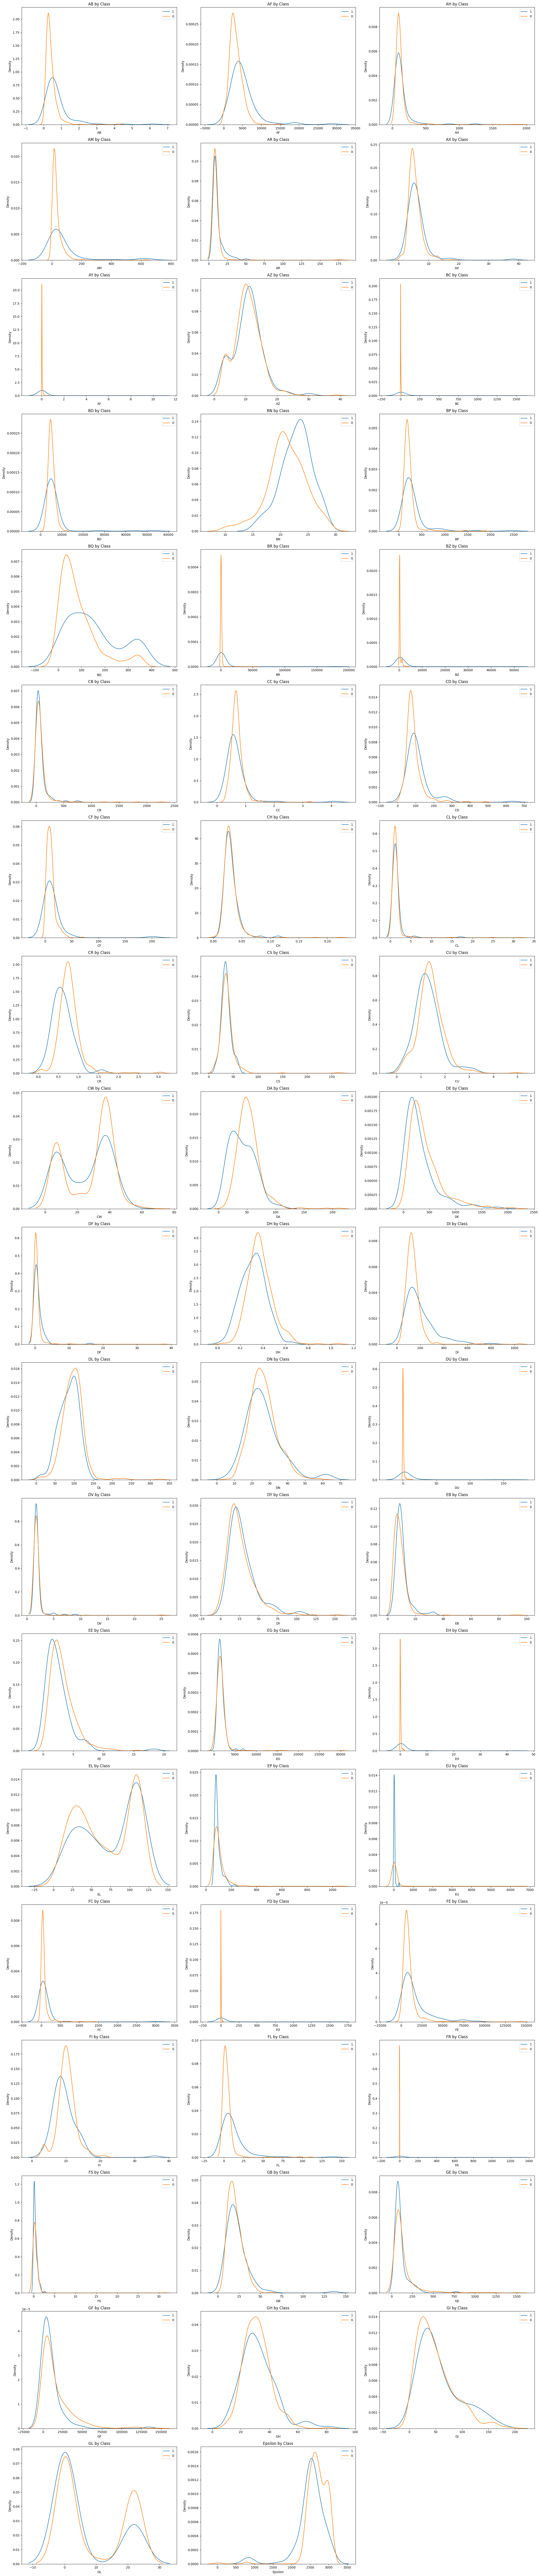

In [294]:
responses = [y_train_class]
features = X_train.columns
n_features = len(features)
n_cols = 3  # number of plots per row
n_rows = math.ceil(n_features / n_cols)  # rows needed per response

# Creating a figure for each response
for response in responses:
    df_1 = X_train[response == 1]
    df_0 = X_train[response == 0]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    axes = axes.ravel()  # flatten the axes array

    for j, feature in enumerate(features):
        ax = axes[j]  # select the current axis
        ax.set_title(f'{feature} by {response.name}')
        sns.kdeplot(df_1[feature], label = '1', ax = ax)
        sns.kdeplot(df_0[feature], label = '0', ax = ax)
        ax.legend()

    # remove the empty subplots
    for i in range(n_features, n_cols * n_rows):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## TSNE

In [295]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3'}
cluster_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

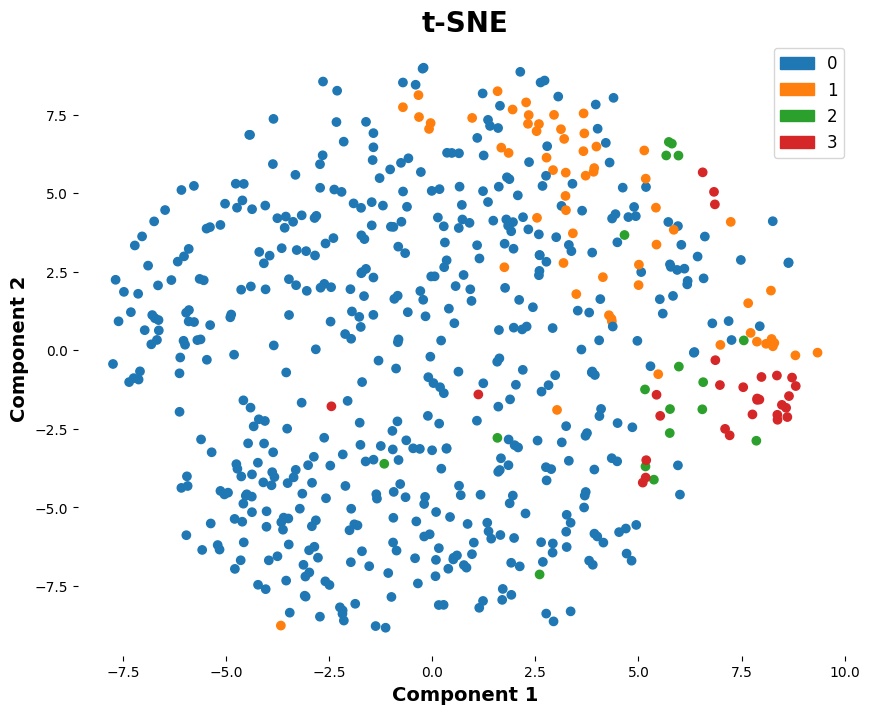

In [296]:
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)

tsne_scaled = StandardScaler().fit_transform(tsne_df)
tsne_transformed = PowerTransformer().fit_transform(tsne_scaled)
tsne_normalized = Normalizer().fit_transform(tsne_transformed)

tsne_df = pd.DataFrame(tsne_normalized, columns = tsne_df.columns, index = tsne_df.index)
tsne = TSNE(n_components = tsne_n, perplexity = 100, random_state = random_seed)
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
X_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = X_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Alpha'] = y_train_alpha

colors = tsne_df['Alpha'].map(alpha_color_map)

legend_elements = [Patch(color = clr, label = lbl) for lbl, clr in alpha_color_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

# Prediction Model

In [297]:
class ICREnsemble(BaseEstimator):
    def __init__(self):
        self.xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        self.xgboost_oversample = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        self.lightgbm_oversample = LGBMClassifier(n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, reg_alpha = 0.01, reg_lambda = 0.1, verbose = -1)
        self.tabpfn_oversample = TabPFNClassifier(N_ensemble_configurations = 64)
               
        self.classifiers_ = [
            ('XGBoost', self.xgboost),
            ('XGBoost Oversample', self.xgboost_oversample),
            ('LightGBM Oversample', self.lightgbm_oversample),
            ('TabPFN Oversample', self.tabpfn_oversample)
        ]
        
        self.classifier_weights_ = [0.10, 0.35, 0.25, 0.30]
        
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer()
        self.normalizer = Normalizer()
        
        self.model_predictions = []
        
        self.random_seed = 101010
    
    def fit(self, X, y):
        # normalize
        X_scaled = self.scaler.fit_transform(X)
        X_transformed = self.transformer.fit_transform(X_scaled)
        X_normalized = self.normalizer.fit_transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        y_norm = y.copy()
        
        # oversample
        X_oversampled, y_oversampled = ADASYN(random_state = self.random_seed).fit_resample(X, y)
        
        # normalize oversampled
        X_norm_oversampled, y_norm_oversampled = ADASYN(random_state = self.random_seed).fit_resample(X_norm, y_norm)
        
        # fit
        clases, y = np.unique(y, return_inverse = True)
        self.classes_ = clases
        for model in self.classifiers_:
            if model[0][0:6] == 'TabPFN':
                if model[0][-15:] == 'Norm Oversample':
                    model[1].fit(X_norm_oversampled, y_norm_oversampled, overwrite_warning = True)
                elif model[0][-10:] == 'Oversample':
                    model[1].fit(X_oversampled, y_oversampled, overwrite_warning = True)
                elif model[0][-4:] == 'Norm':
                    model[1].fit(X_norm, y_norm, overwrite_warning = True)
                else:
                    model[1].fit(X, y, overwrite_warning = True)
            else:
                if model[0][-15:] == 'Norm Oversample':
                    model[1].fit(X_norm_oversampled, y_norm_oversampled)
                elif model[0][-10:] == 'Oversample':
                    model[1].fit(X_oversampled, y_oversampled)
                elif model[0][-4:] == 'Norm':
                    model[1].fit(X_norm, y_norm)
                else:
                    model[1].fit(X, y)
                
            
    def predict_proba(self, X):
        # normalize
        X_scaled = self.scaler.transform(X)
        X_transformed = self.transformer.transform(X_scaled)
        X_normalized = self.normalizer.transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        
        probabilities = []
        weights = self.classifier_weights_
        for model in self.classifiers_:
            if model[0][-4:] == 'Norm' or model[0][-15:] == 'Norm Oversample':
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
                
        probabilities = np.stack(probabilities)
        self.model_predictions = probabilities
        
        if weights is None:
            weights = np.ones(len(self.classifiers_)) / len(self.classifiers_)

        assert len(weights) == probabilities.shape[0], 'weights should have same length as number of classifiers_'

        weighted_probabilities = np.average(probabilities, axis = 0, weights = weights)
            
        y_proba_0 = weighted_probabilities[:, 0 ].sum()
        y_proba_1 = weighted_probabilities[:, 1:].sum()
            
        new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
            
        return new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    def predict_proba_individual(self, X):
        # normalize
        X_scaled = self.scaler.transform(X)
        X_transformed = self.transformer.transform(X_scaled)
        X_normalized = self.normalizer.transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        
        probabilities = []
        probabilities_cols = []
        for model in self.classifiers_:
            if model[0][-4:] == 'Norm' or model[0][-15:] == 'Norm Oversample':
                probabilities.append(model[1].predict_proba(X_norm))
            else:
                probabilities.append(model[1].predict_proba(X))
            
            for class_ in model[1].classes_:
                probabilities_cols.append(model[0] + '_' + str(class_))
        
        return pd.DataFrame(np.concatenate(probabilities, axis = 1), columns = probabilities_cols, index = X.index)
    
    def to_pickel(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

In [298]:
def model_fit_predict(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    if model_name == 'TabPFN':
        model.fit(X, y, overwrite_warning = True)
    else:
        model.fit(X, y)
        
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [299]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

### Model Evaluation

In [300]:
model = ICREnsemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [301]:
prediction_cols = X_train.columns.to_list()
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
ensemble_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # fit and predict
    predictions_df = model_fit_predict('Ensemble', model, fold, fold_y, oof, prediction_cols)

    # combine predictions
    ensemble_df = pd.concat([ensemble_df, predictions_df])

# add meta features
ensemble_df.sort_index(inplace = True)

In [302]:
model_prediction_cols = ensemble_df.columns.to_list()
ensemble_df['Class'] = y_train_class

roc_auc = []
log_loss = []
    
def row_log_loss(row):
    if row['Class'] == 0:
        return -np.log(1 - row['Ensemble_1'])
    else:
        return -np.log(row['Ensemble_1'])
    
ensemble_df['Log Loss'] = ensemble_df.apply(row_log_loss, axis = 1)

def classify_error_types(row):
    if row['Class'] == 0 and row['Ensemble_1'] > 0.5:
        return 'False Positive'
    elif row['Class'] == 1 and row['Ensemble_1'] < 0.5:
        return 'False Negative'
    elif row['Class'] == 0 and row['Ensemble_1'] < 0.5:
        return 'True Negative'
    elif row['Class'] == 1 and row['Ensemble_1'] >= 0.5:
        return 'True Positive'
    
ensemble_df['Error Type'] = ensemble_df.apply(classify_error_types, axis = 1)
y_train_error_type = ensemble_df['Error Type']

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(ensemble_df['Class'], ensemble_df[col]))
    print('Log Loss:', competition_log_loss(ensemble_df['Class'], ensemble_df[col]))

ensemble_df.sort_values(by = 'Log Loss', ascending = False).head(25)

Ensemble_1
ROC AUC: 0.9784253801935531
Log Loss: 0.18462730659378376


,Ensemble_1,Class,Log Loss,Error Type
393,0.003217,1,5.739332,False Negative
83,0.989435,0,4.550212,False Positive
429,0.961676,0,3.261683,False Positive
114,0.046871,1,3.060361,False Negative
150,0.930418,0,2.665256,False Positive
173,0.922150,0,2.552973,False Positive
612,0.918774,0,2.510526,False Positive
214,0.913181,0,2.443935,False Positive
223,0.905740,0,2.361696,False Positive
357,0.872683,0,2.061074,False Positive


### False Positive Predictions

In [303]:
X_train_1 = X_train[ensemble_df['Ensemble_1'] > 0.5].copy()
y_pred_class_1 = ensemble_df[ensemble_df['Ensemble_1'] > 0.5]['Ensemble_1'].copy()
y_train_class_1 = y_train_class[ensemble_df['Ensemble_1'] > 0.5].copy()

In [328]:
prediction_cols = X_train.columns.to_list()
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
post_ensemble_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train_1, y_train_class_1)):
    fold, oof = X_train_1.iloc[train_index], X_train_1.iloc[test_index]
    fold_y, oof_y = y_train_class_1.iloc[train_index], y_train_class_1.iloc[test_index]
    
    # fit and predict
    predictions_df = model_fit_predict('Ensemble', model, fold, fold_y, oof, prediction_cols)

    # combine predictions
    post_ensemble_df = pd.concat([post_ensemble_df, predictions_df])

# add meta features
post_ensemble_df.sort_index(inplace = True)

In [329]:
model_prediction_cols = post_ensemble_df.columns.to_list()
post_ensemble_df['Class'] = y_train_class_1

roc_auc = []
log_loss = []
    
def row_log_loss(row):
    if row['Class'] == 0:
        return -np.log(1 - row['Ensemble_1'])
    else:
        return -np.log(row['Ensemble_1'])
    
post_ensemble_df['Log Loss'] = post_ensemble_df.apply(row_log_loss, axis = 1)

def classify_error_types(row):
    if row['Class'] == 0 and row['Ensemble_1'] > 0.5:
        return 'False Positive'
    elif row['Class'] == 1 and row['Ensemble_1'] < 0.5:
        return 'False Negative'
    elif row['Class'] == 0 and row['Ensemble_1'] < 0.5:
        return 'True Negative'
    elif row['Class'] == 1 and row['Ensemble_1'] >= 0.5:
        return 'True Positive'
    
post_ensemble_df['Error Type'] = post_ensemble_df.apply(classify_error_types, axis = 1)
y_train_error_type = post_ensemble_df['Error Type']

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(post_ensemble_df['Class'], post_ensemble_df[col]))
    print('Log Loss:', competition_log_loss(post_ensemble_df['Class'], post_ensemble_df[col]))

post_ensemble_df.sort_values(by = 'Log Loss', ascending = False).head(25)

Ensemble_1
ROC AUC: 0.7269677996422182
Log Loss: 0.6486330846627708


,Ensemble_1,Class,Log Loss,Error Type
75,0.027477,1,3.594414,False Negative
143,0.028886,1,3.544403,False Negative
354,0.947691,0,2.950587,False Positive
274,0.947197,0,2.941187,False Positive
339,0.085486,1,2.459400,False Negative
398,0.123318,1,2.092991,False Negative
23,0.124996,1,2.079474,False Negative
388,0.151892,1,1.884584,False Negative
287,0.802271,0,1.620859,False Positive
286,0.210542,1,1.558070,False Negative


In [330]:
ensemble_scaler = StandardScaler()
ensemble_scaler.fit(ensemble_df[ensemble_df['Ensemble_1'] > 0.5]['Ensemble_1'].values.reshape(-1, 1))

StandardScaler()

In [331]:
post_ensemble_scaler = StandardScaler()
post_ensemble_pred_z = post_ensemble_scaler.fit_transform(post_ensemble_df['Ensemble_1'].values.reshape(-1, 1))
post_enemble_pred = ensemble_scaler.inverse_transform(post_ensemble_pred_z)
post_ensemble_df['Ensemble_1'] = post_enemble_pred
post_ensemble_df['Ensemble_1'].clip(0, 1, inplace = True)

In [332]:
combined_df = ensemble_df.copy()
combined_df.update(post_ensemble_df)
combined_df

,Ensemble_1,Class,Log Loss,Error Type
0,1.000000,1,0.148543,True Positive
1,0.931117,1,0.346648,True Positive
2,0.000593,0,0.000593,True Negative
3,0.013389,0,0.013479,True Negative
4,0.011628,0,0.011696,True Negative
...,...,...,...,...
612,0.914855,0,1.127875,False Positive
613,0.018053,0,0.018218,True Negative
614,0.388331,0,0.491564,True Negative
615,0.008526,0,0.008563,True Negative


In [340]:
combined_df.sort_values(by = 'Log Loss', ascending = False).head(25)


,Ensemble_1,Class,Log Loss,Error Type
274,1.000000,0,inf,False Positive
354,1.000000,0,inf,False Positive
287,0.981431,0,3.986242,False Positive
610,0.962087,0,3.272462,False Positive
278,0.942294,0,2.852394,False Positive
590,0.940578,0,2.823085,False Positive
173,0.938153,0,2.783097,False Positive
214,0.922047,0,2.551647,False Positive
611,0.916128,0,2.478461,False Positive
612,0.914855,0,2.463404,False Positive


In [333]:
competition_log_loss(combined_df['Class'], combined_df['Ensemble_1'])

0.28140457946525405

In [271]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'n_estimators': [10, 25, 50, 100, 250],
    'max_depth': [6],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
    'subsample': [0.5, 0.75, 1],
    'booster': ['gbtree'],
    'tree_method': ['auto', 'hist']
}

grid_obj = GridSearchCV(xgb, parameters, scoring = 'f1', cv = 5)
grid_obj = grid_obj.fit(X_train_1, y_train_class_1)
xgb = grid_obj.best_estimator_
xgb.fit(X_train_1, y_train_class_1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=101010,
              reg_alpha=0, reg_lambda=1, ...)

In [272]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.042972,0.008554,0.002469,0.000059,gbtree,0.01,6,50,0.75,auto,"{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.893617,0.840000,0.816327,0.816327,0.816327,0.836519,0.029985,1
55,0.121491,0.012504,0.002529,0.000545,gbtree,0.02,6,250,0.5,hist,"{'booster': 'gbtree', 'learning_rate': 0.02, '...",0.875000,0.800000,0.840000,0.875000,0.791667,0.836333,0.035550,2
123,0.009887,0.001737,0.001914,0.000070,gbtree,0.1,6,10,0.75,hist,"{'booster': 'gbtree', 'learning_rate': 0.1, 'm...",0.875000,0.808511,0.840000,0.840000,0.816327,0.835967,0.023219,3
141,0.043770,0.001819,0.002090,0.000111,gbtree,0.1,6,100,0.75,hist,"{'booster': 'gbtree', 'learning_rate': 0.1, 'm...",0.851064,0.833333,0.816327,0.857143,0.816327,0.834839,0.017020,4
50,0.051883,0.003835,0.002191,0.000073,gbtree,0.02,6,100,0.75,auto,"{'booster': 'gbtree', 'learning_rate': 0.02, '...",0.857143,0.823529,0.816327,0.857143,0.816327,0.834094,0.019003,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,0.009956,0.000620,0.001913,0.000072,gbtree,0.02,6,10,1,hist,"{'booster': 'gbtree', 'learning_rate': 0.02, '...",0.790698,0.761905,0.744186,0.790698,0.782609,0.774019,0.018259,146
17,0.056589,0.009002,0.002307,0.000099,gbtree,0.01,6,50,1,hist,"{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.772727,0.772727,0.755556,0.790698,0.765957,0.771533,0.011459,147
40,0.018434,0.004916,0.002156,0.000351,gbtree,0.02,6,25,1,auto,"{'booster': 'gbtree', 'learning_rate': 0.02, '...",0.772727,0.780488,0.772727,0.744186,0.765957,0.767217,0.012400,148
5,0.011872,0.003291,0.002018,0.000166,gbtree,0.01,6,10,1,hist,"{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.818182,0.761905,0.727273,0.790698,0.727273,0.765066,0.035623,149


### Model Weights Optimization

In [210]:
from scipy.optimize import minimize
from scipy.special import logit

# Define your objective function: the metric you want to optimize
def objective(weights: np.array, pred_df: pd.DataFrame, y_train_class: np.array):
    ''' Calculate the competition log loss of predictions from a weighted ensemble of models '''
    
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    
    # Compute the weighted average prediction
    weighted_average_prediction = pred_df.apply(lambda row: np.sum(normalized_weights * row), axis=1)
    
    p_0 = 1 - weighted_average_prediction
    p_1 = weighted_average_prediction
    weighted_probabilities = np.stack([p_0, p_1], axis = 1)
    y_proba_0 = weighted_probabilities[:, 0].sum()
    y_proba_1 = weighted_probabilities[:, 1].sum()
    
    new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
    new_probabilities = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    y_pred = new_probabilities[:, 1]
    
    # Calculate log loss
    log_loss = competition_log_loss(y_train_class, y_pred)  # assuming you have defined `competition_log_loss` elsewhere
    
    # Return log loss
    return log_loss

# Set initial guess (equal weights)
init_guess = [1 / len(pred_df.columns)] * len(pred_df.columns)

# Create bounds and constraints
bounds = [(0, 1) for _ in range(len(pred_df.columns))]
cons = ({'type': 'eq', 'fun': lambda w: 1-sum(w)})

# Run the optimizer
result = minimize(objective, init_guess, args=(pred_df, y_train_class), method='SLSQP', bounds=bounds, constraints=cons)

# Get the optimal weights
optimal_weights = result.x

### Important Featues

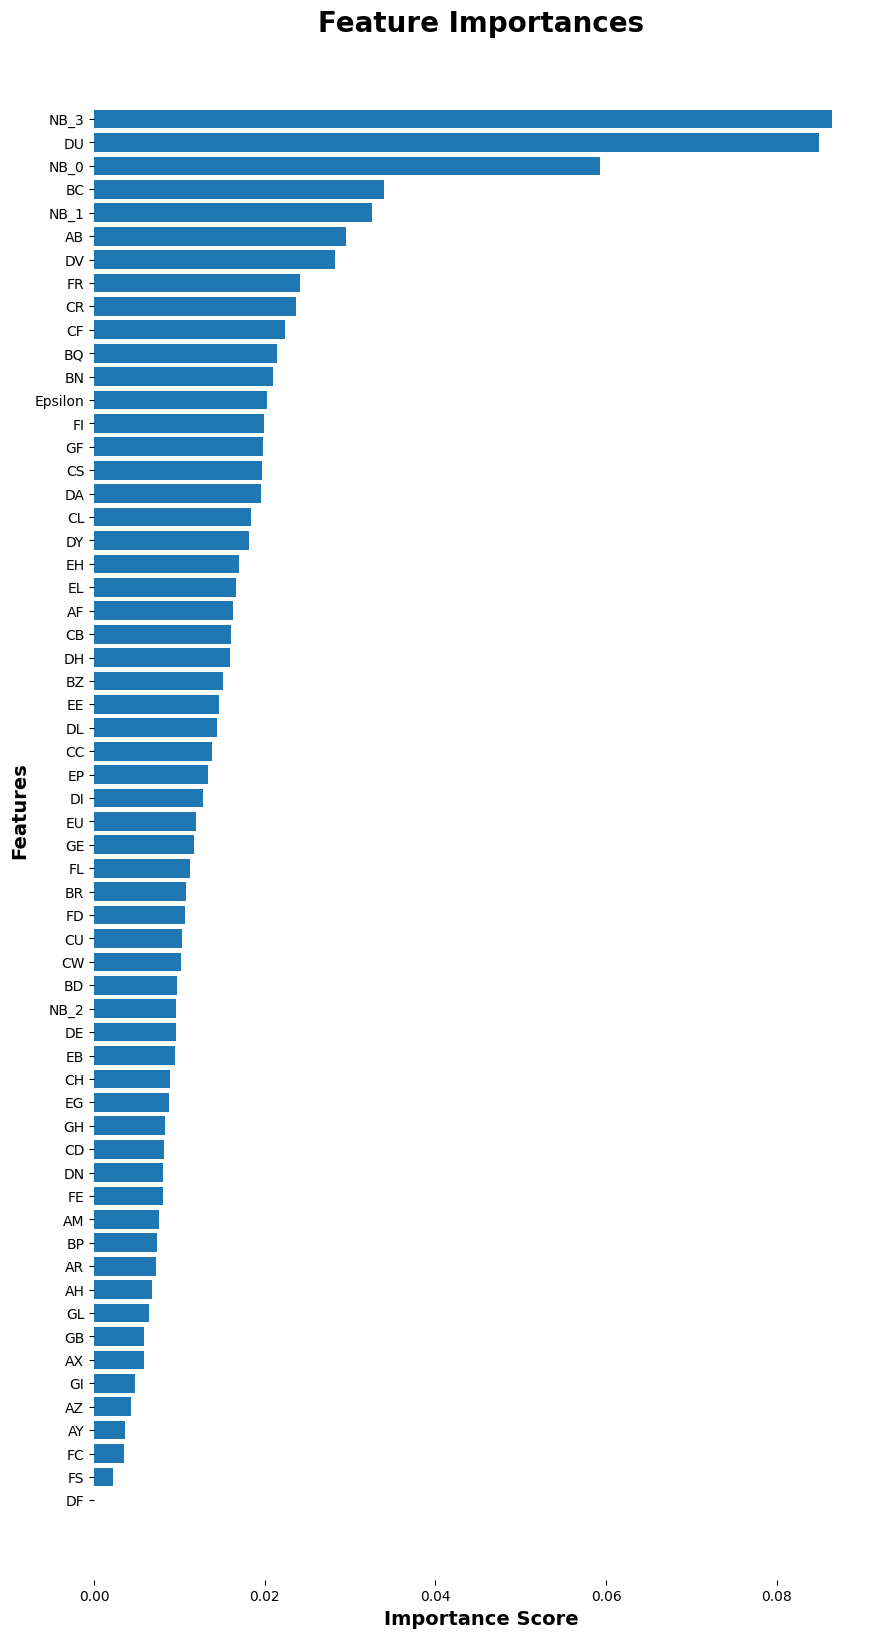

In [214]:
feature_model = model.classifiers_[1][1]
importances = pd.Series(feature_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Visualize Errors

In [28]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

In [235]:
# TSNE
tsne_df['Error Type'] = y_train_error_type

error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C3', 'False Negative': 'C4'}
colors = tsne_df['Error Type'].map(error_type_map)

# map error types to sizes
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

legend_elements = [Patch(color=clr, label=lbl) for lbl, clr in error_type_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


NameError: name 'y_train_error_type' is not defined

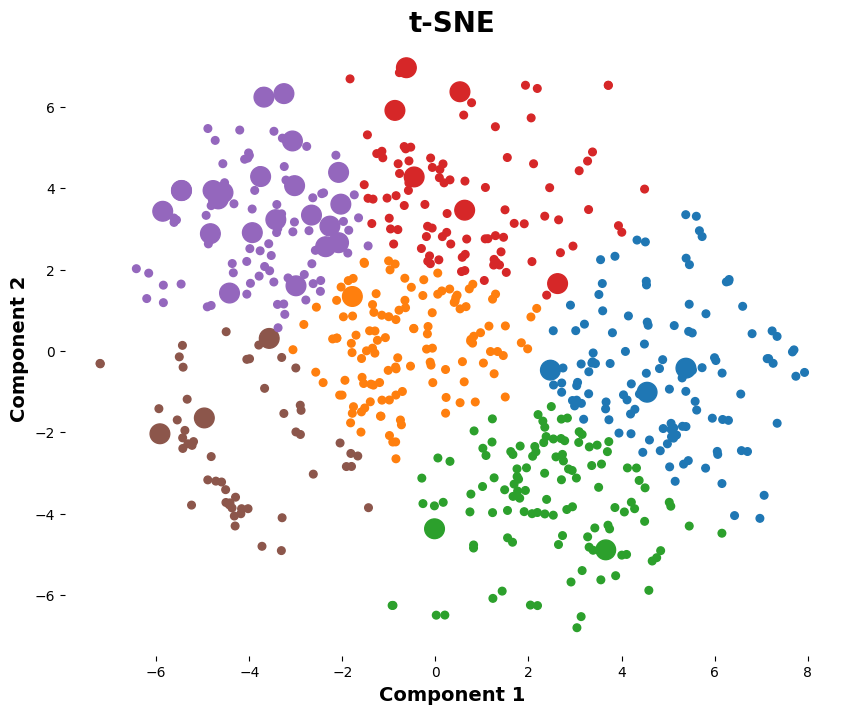

In [32]:
# TSNE
colors = tsne_df['Cluster'].map(cluster_map)

# map error types to sizes
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

legend_elements = [Patch(color=clr, label=lbl) for lbl, clr in error_type_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

# Submission

In [33]:
def prediction_pipeline(X, features):
    # pre-process
    X = X.copy()
    X.columns = X.columns.str.strip()
    X['Epsilon'] = X_train['Epsilon'].max() + 1
    X = X[features]
    imputed = knn_imputer.transform(X)
    X = pd.DataFrame(imputed, columns = X.columns, index = X.index)
    
    # fit model and predict
    model.fit(X_train, y_train_class)
    X[['class_0', 'class_1']] = model.predict_proba(X)
    
    return X

In [34]:
X_test = prediction_pipeline(test_df, prediction_cols)

In [35]:
submission_df = pd.concat([test_df[['Id']], X_test[['class_0', 'class_1']]], axis = 1)
submission_df.to_csv('submission.csv', index = False)
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
